<a href="https://colab.research.google.com/github/Sergei-Volkov/CellsCounter/blob/main/NeuralNetworkTry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import os
import cv2 as cv
import albumentations as A

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/ООП проект/SyntheticCellsDataset'
os.chdir(path)

# Train & Test datasets

In [ ]:
def get_files_names(path: str):
    files_images, files_masks = [], []
    for percent in ['00', '15', '30', '45', '60']:
        files_images_temp = next(os.walk(path + '/synthetic_0' + percent + '_images'))
        files_images += [files_images_temp[0] + '/' + name for name in sorted(files_images_temp[-1], key=lambda k: int(k[:-8]))]
        files_masks_temp = next(os.walk(path + '/synthetic_0' + percent + '_foreground'))
        files_masks += [files_masks_temp[0] + '/' + name for name in sorted(files_masks_temp[-1], key=lambda k: int(k[:-4]))]
    return np.array(files_images), np.array(files_masks)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    *get_files_names(path),
    test_size=0.3,
    random_state=12345
)

In [ ]:
Y_test

array(['/content/drive/MyDrive/ООП проект/SyntheticCellsDataset/synthetic_045_foreground/10.tif',
       '/content/drive/MyDrive/ООП проект/SyntheticCellsDataset/synthetic_015_foreground/14.tif',
       '/content/drive/MyDrive/ООП проект/SyntheticCellsDataset/synthetic_060_foreground/7.tif',
       '/content/drive/MyDrive/ООП проект/SyntheticCellsDataset/synthetic_045_foreground/1.tif',
       '/content/drive/MyDrive/ООП проект/SyntheticCellsDataset/synthetic_015_foreground/1.tif',
       '/content/drive/MyDrive/ООП проект/SyntheticCellsDataset/synthetic_030_foreground/10.tif',
       '/content/drive/MyDrive/ООП проект/SyntheticCellsDataset/synthetic_045_foreground/4.tif',
       '/content/drive/MyDrive/ООП проект/SyntheticCellsDataset/synthetic_030_foreground/3.tif',
       '/content/drive/MyDrive/ООП проект/SyntheticCellsDataset/synthetic_060_foreground/9.tif',
       '/content/drive/MyDrive/ООП проект/SyntheticCellsDataset/synthetic_015_foreground/16.tif',
       '/content/drive/MyD

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Batcher with augmentation

In [ ]:
def strong_aug(input_size, p=0.7):
    return A.Compose([
        A.RandomCrop(input_size, input_size, always_apply=True),
        A.ShiftScaleRotate(shift_limit=10, scale_limit=0.2, rotate_limit=180, p=0.8),
        A.IAAAdditiveGaussianNoise(scale=(0.01, 0.05), p=1),
        # A.RandomBrightnessContrast(p=1),

    ], p=p)


def batch_generator(
    files_images: np.ndarray, 
    files_masks: np.ndarray, 
    batch_size: int, 
    input_size=256
    ):
    dataset_size = files_images.size
    while True:
        x_batch = []
        y_batch = []
        
        # берем рандомные пути к изображениям из нашего датасета и считываем их
        for i in np.random.randint(dataset_size, size=batch_size):
            img = cv.imread(files_images[i])
            mask = cv.imread(files_masks[i])

            # применяем аугментацию
            augmentation = strong_aug(input_size=input_size)  
            aug = augmentation(image=img.astype('uint8'), mask=mask)
            
            x_batch += [aug['image']]
            y_batch += [aug['mask'][..., 0]]

        # приводим числа к одному масштабу
        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch) / 255.

        # у получился без 4 размерности, делаем ее искусственно 
        yield x_batch, np.expand_dims(y_batch, -1)

In [ ]:
imgs, masks = next(batch_generator(X_test, Y_test, 16))

In [ ]:
imgs.shape, masks.shape

((16, 256, 256, 3), (16, 256, 256, 1))

In [ ]:
np.unique(masks[0])

array([0., 1.])

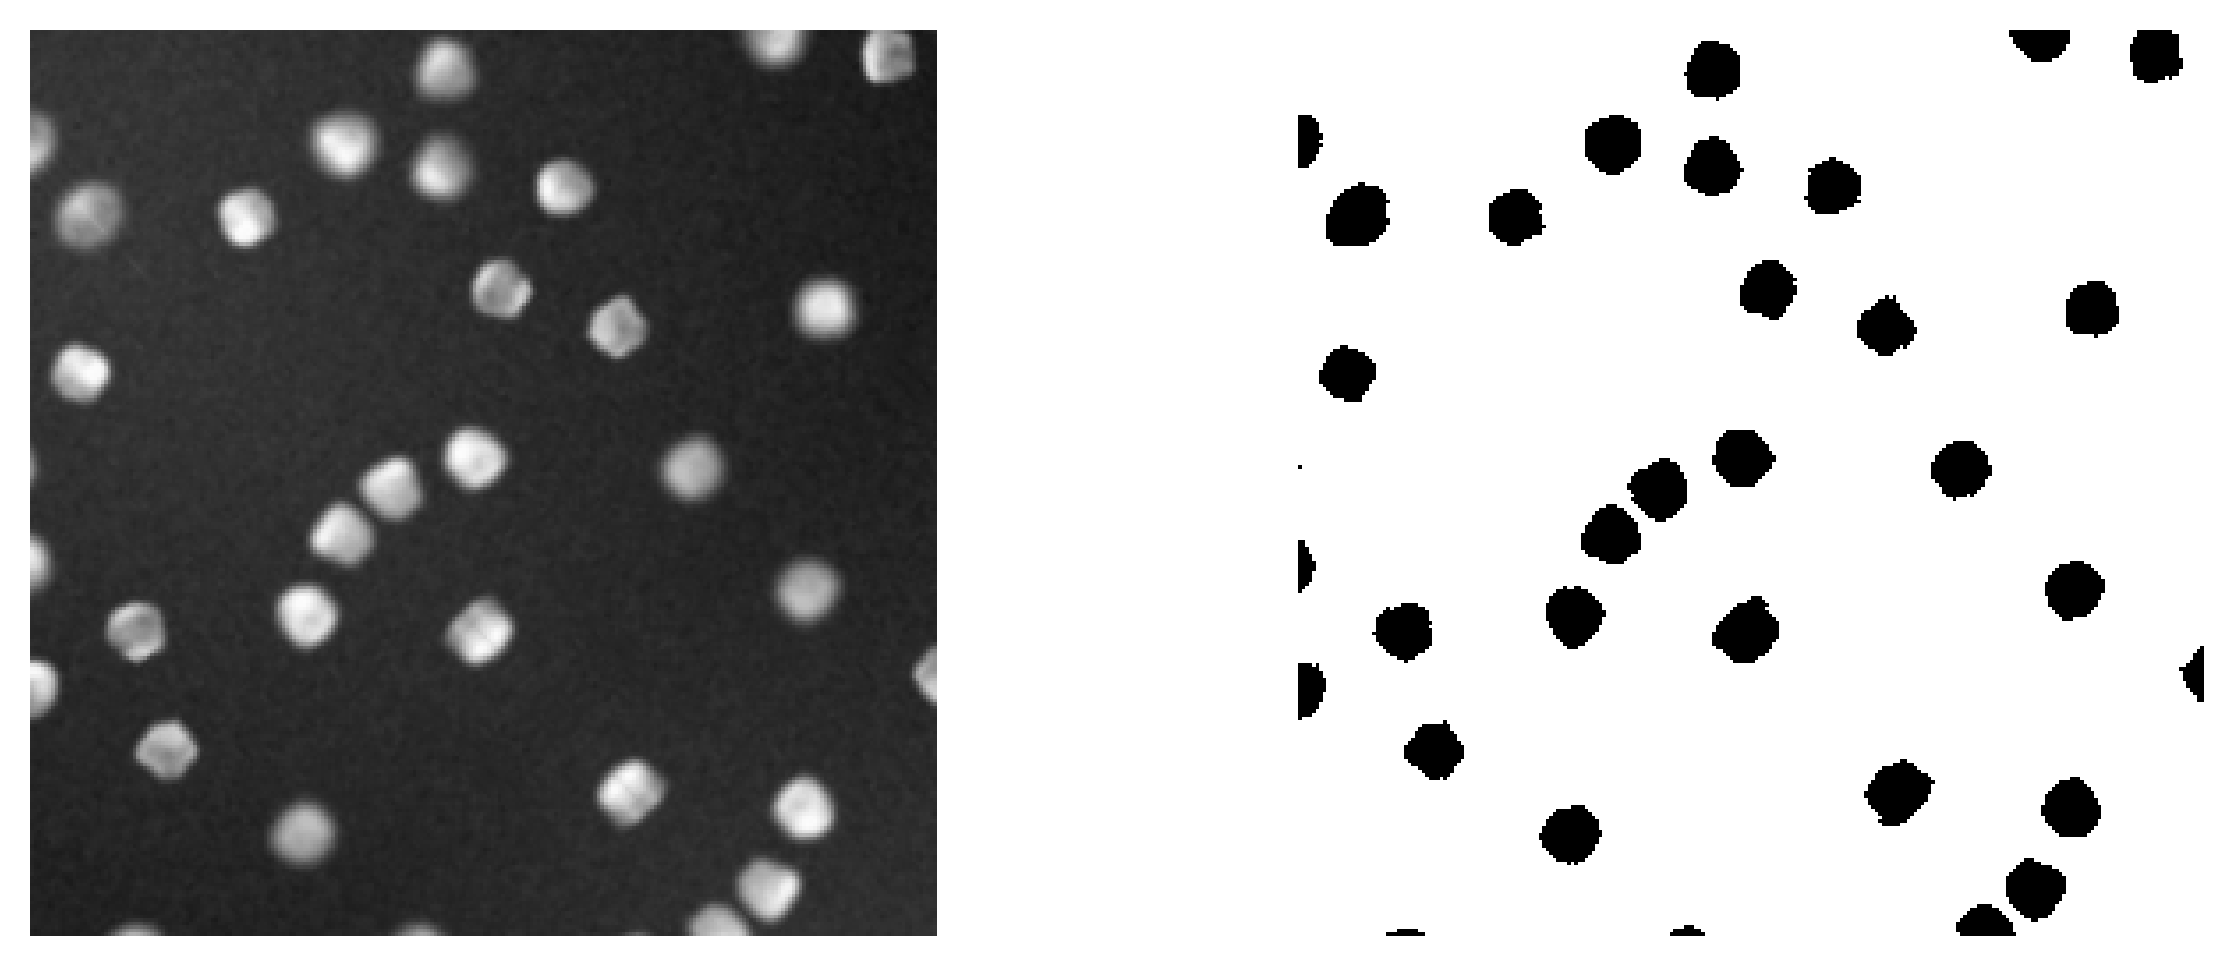

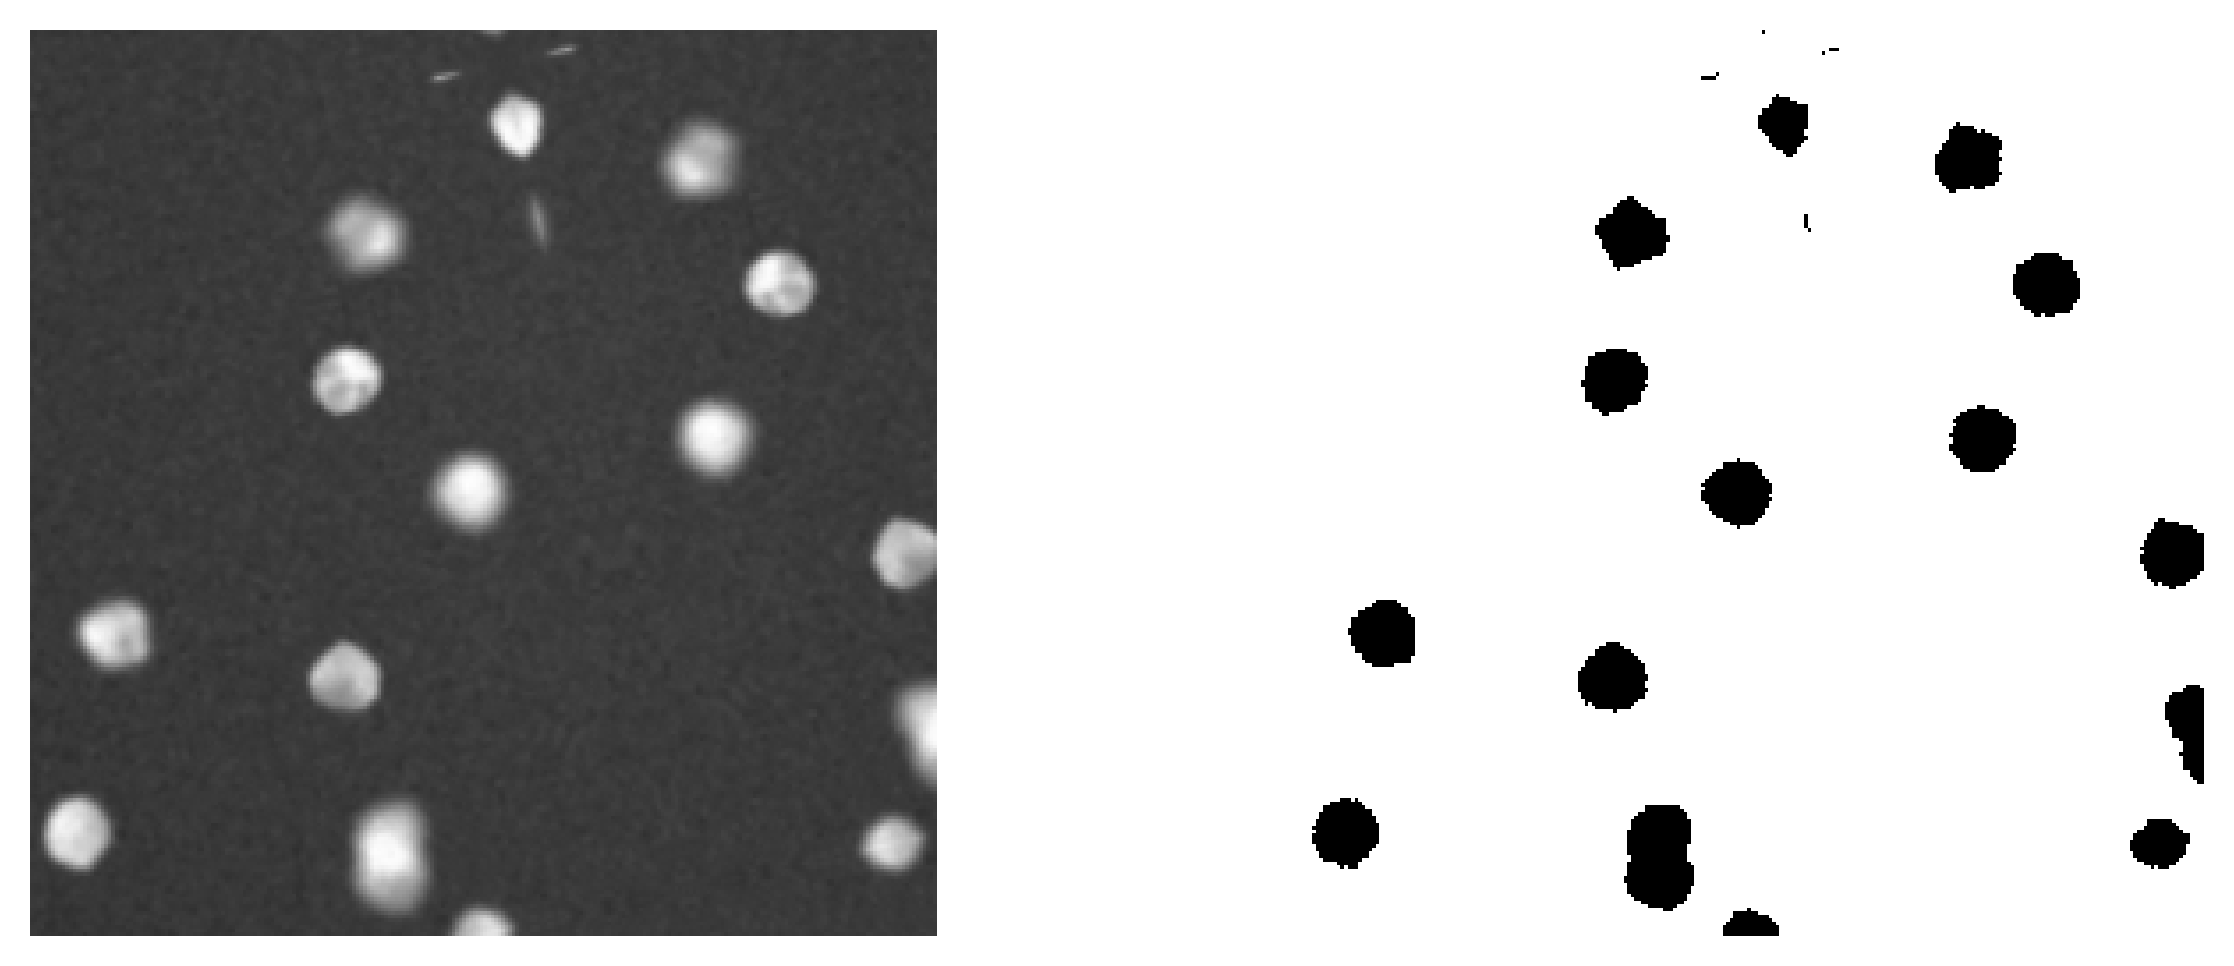

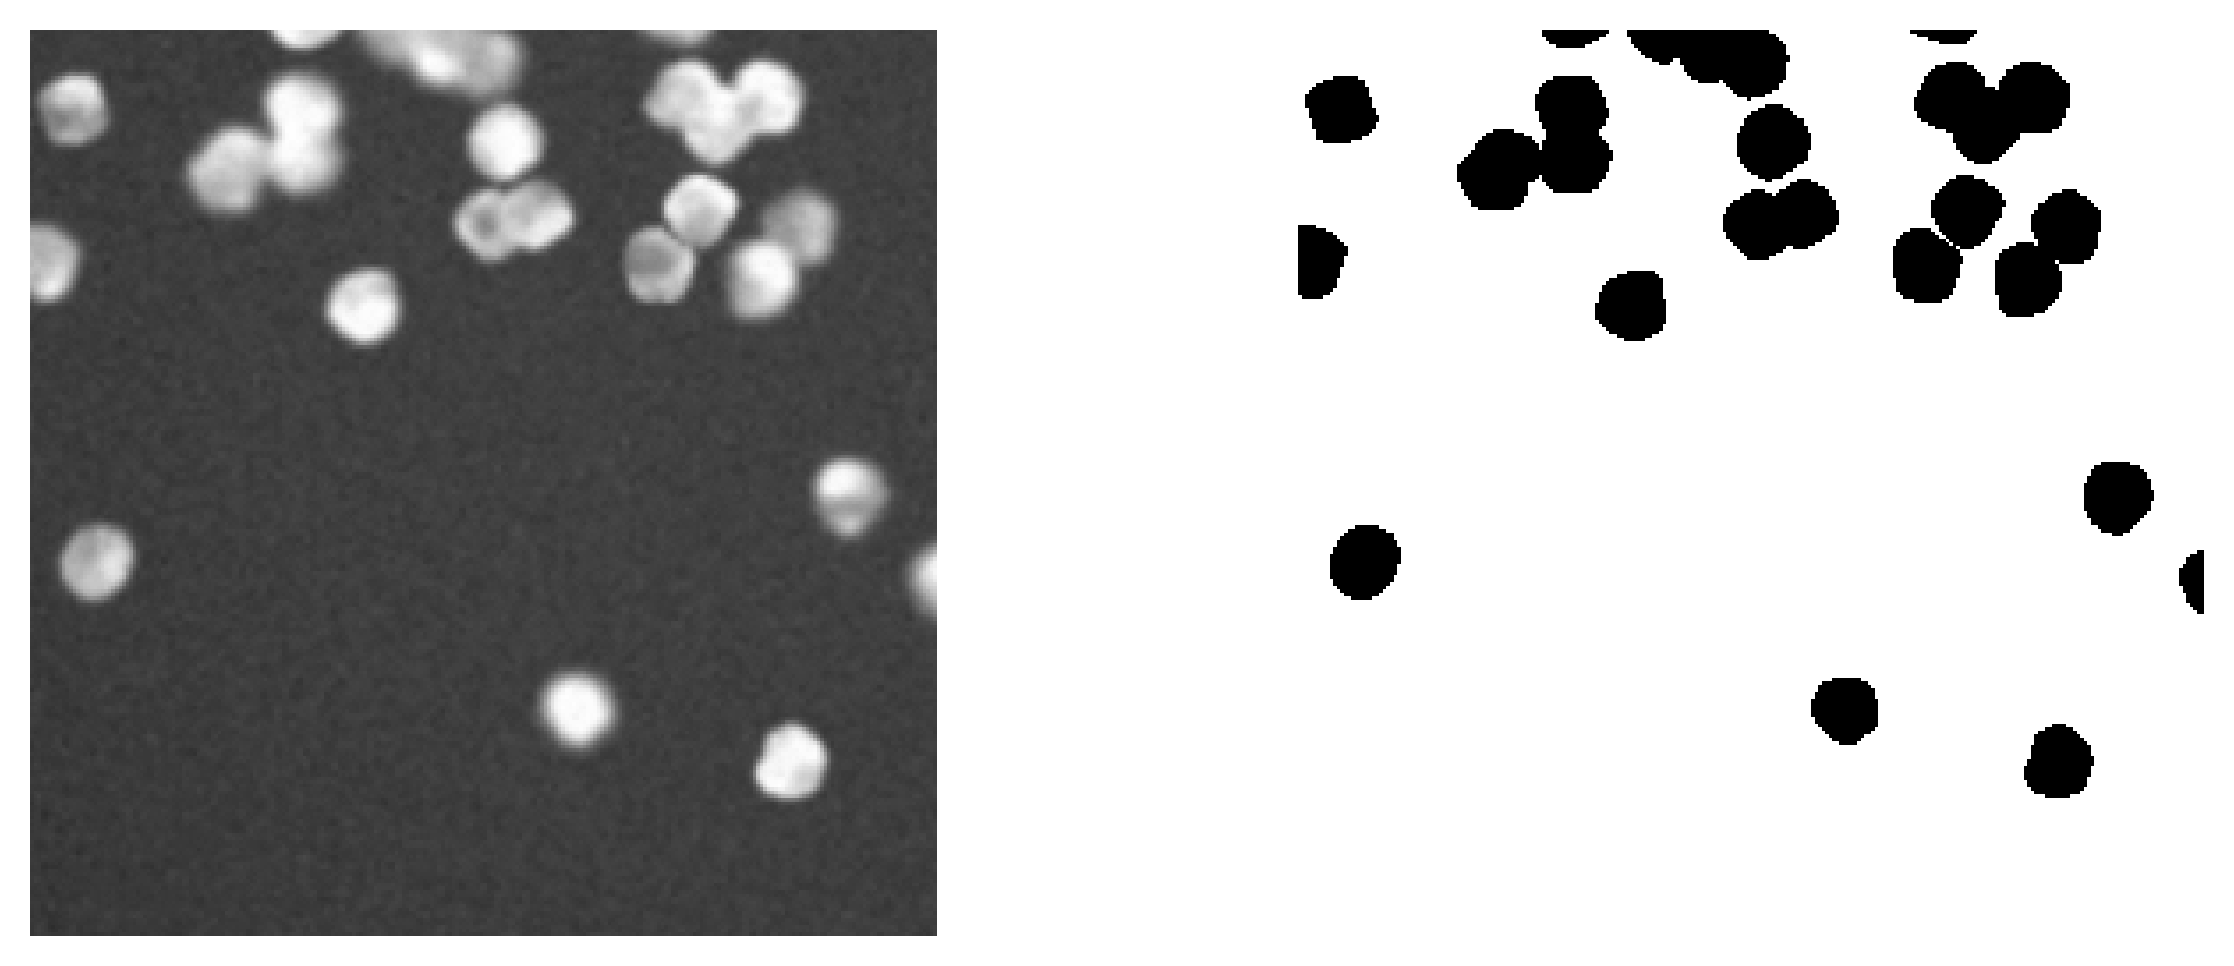

In [ ]:
for j in np.random.randint(16, size=3):
    plt.figure(dpi=300, figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(imgs[j], cmap='Greys')
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(masks[j, ..., 0], cmap='Greys')

# Neural network architecture

In [ ]:
import keras
import tensorflow as tf
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Input, Dense, Concatenate, GlobalAveragePooling2D, Dropout, UpSampling2D, MaxPooling2D, Activation
from keras.layers import Conv2D
import keras.backend as K

In [ ]:
base_model = ResNet50(weights='imagenet', input_shape=(256,256,3), include_top=False)
 
base_out = base_model.output

In [ ]:
base_out

<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
conv1 = base_model.get_layer('conv1_relu').output
conv2 = base_model.get_layer('conv2_block3_out').output
conv3 = base_model.get_layer('conv3_block4_out').output
conv4 = base_model.get_layer('conv4_block6_out').output
conv5 = base_model.get_layer('conv5_block3_out').output

In [ ]:
print(conv1.shape)
print(conv2.shape)
print(conv3.shape)
print(conv4.shape)
print(conv5.shape)

(None, 128, 128, 64)
(None, 64, 64, 256)
(None, 32, 32, 512)
(None, 16, 16, 1024)
(None, 8, 8, 2048)


In [ ]:
inp = base_model.get_layer(base_model.layers[0].name).output

In [ ]:
inp

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_3')>

In [ ]:
up1 = UpSampling2D(2, interpolation='bilinear')(conv5)
conc_1 = Concatenate()([up1, conv4])
conv_conc_1 = Conv2D(256, (3, 3), padding='same')(conc_1)
conv_conc_1 = Activation('relu')(conv_conc_1)

up2 = UpSampling2D(2, interpolation='bilinear')(conv_conc_1)
conc_2 = Concatenate()([up2, conv3])
conv_conc_2 = Conv2D(128, (3, 3), padding='same')(conc_2)
conv_conc_2 = Activation('relu')(conv_conc_2)

up3 = UpSampling2D(2, interpolation='bilinear')(conv_conc_2)
conc_3 = Concatenate()([up3, conv2])
conv_conc_3 = Conv2D(64, (3, 3), padding='same')(conc_3)
conv_conc_3 = Activation('relu')(conv_conc_3)

up4 = UpSampling2D(2, interpolation='bilinear')(conv_conc_3)
conc_4 = Concatenate()([up4, conv1])
conv_conc_4 = Conv2D(32, (3, 3), padding='same')(conc_4)
conv_conc_4 = Activation('relu')(conv_conc_4)

up5 = UpSampling2D(2, interpolation='bilinear')(conv_conc_4)
conv_conc_5 = Conv2D(1, (3, 3), padding='same')(up5)
conv_conc_5 = Activation('sigmoid')(conv_conc_5)

In [ ]:
conv_conc_5

<KerasTensor: shape=(None, 256, 256, 1) dtype=float32 (created by layer 'activation_14')>

In [ ]:
model = Model(base_model.input, conv_conc_5)

# Neural network training

In [ ]:
best_w = keras.callbacks.ModelCheckpoint(
    'unet_best.h5',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode='auto'
)

last_w = keras.callbacks.ModelCheckpoint(
    'unet_last.h5',
    monitor='val_loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=True,
    mode='auto'
)


callbacks = [best_w, last_w]

lr_scheduler = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=0.001,
    decay_steps=500,
    end_learning_rate=0.0000005,
    power=1.0,
    cycle=True
)


def dice_loss(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (
        (2. * intersection + smooth) / 
        (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)
    )


adam = keras.optimizers.Adam(lr_scheduler)

model.compile(adam, loss='binary_crossentropy', metrics=[dice_loss])

In [ ]:
batch_size = 16
history = model.fit(
    batch_generator(X_train, Y_train, batch_size),
    steps_per_epoch=100,
    epochs=5,
    verbose=1,
    callbacks=callbacks,
    validation_data=batch_generator(X_test, Y_test, batch_size),
    validation_steps=50,
    class_weight=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    shuffle=True,
    initial_epoch=0
)

Epoch 1/5
100/100 [==============================] - 67s 621ms/step - loss: 0.3983 - dice_loss: 0.9756 - val_loss: 0.5308 - val_dice_loss: 0.9509
Epoch 2/5
100/100 [==============================] - 62s 623ms/step - loss: 0.0192 - dice_loss: 0.9967 - val_loss: 0.7303 - val_dice_loss: 0.9502
Epoch 3/5
100/100 [==============================] - 62s 619ms/step - loss: 0.0160 - dice_loss: 0.9972 - val_loss: 0.6694 - val_dice_loss: 0.9512
Epoch 4/5
100/100 [==============================] - 61s 611ms/step - loss: 0.0137 - dice_loss: 0.9976 - val_loss: 0.7210 - val_dice_loss: 0.9504
Epoch 5/5
100/100 [==============================] - 61s 613ms/step - loss: 0.0132 - dice_loss: 0.9977 - val_loss: 0.6514 - val_dice_loss: 0.9508


# Training results

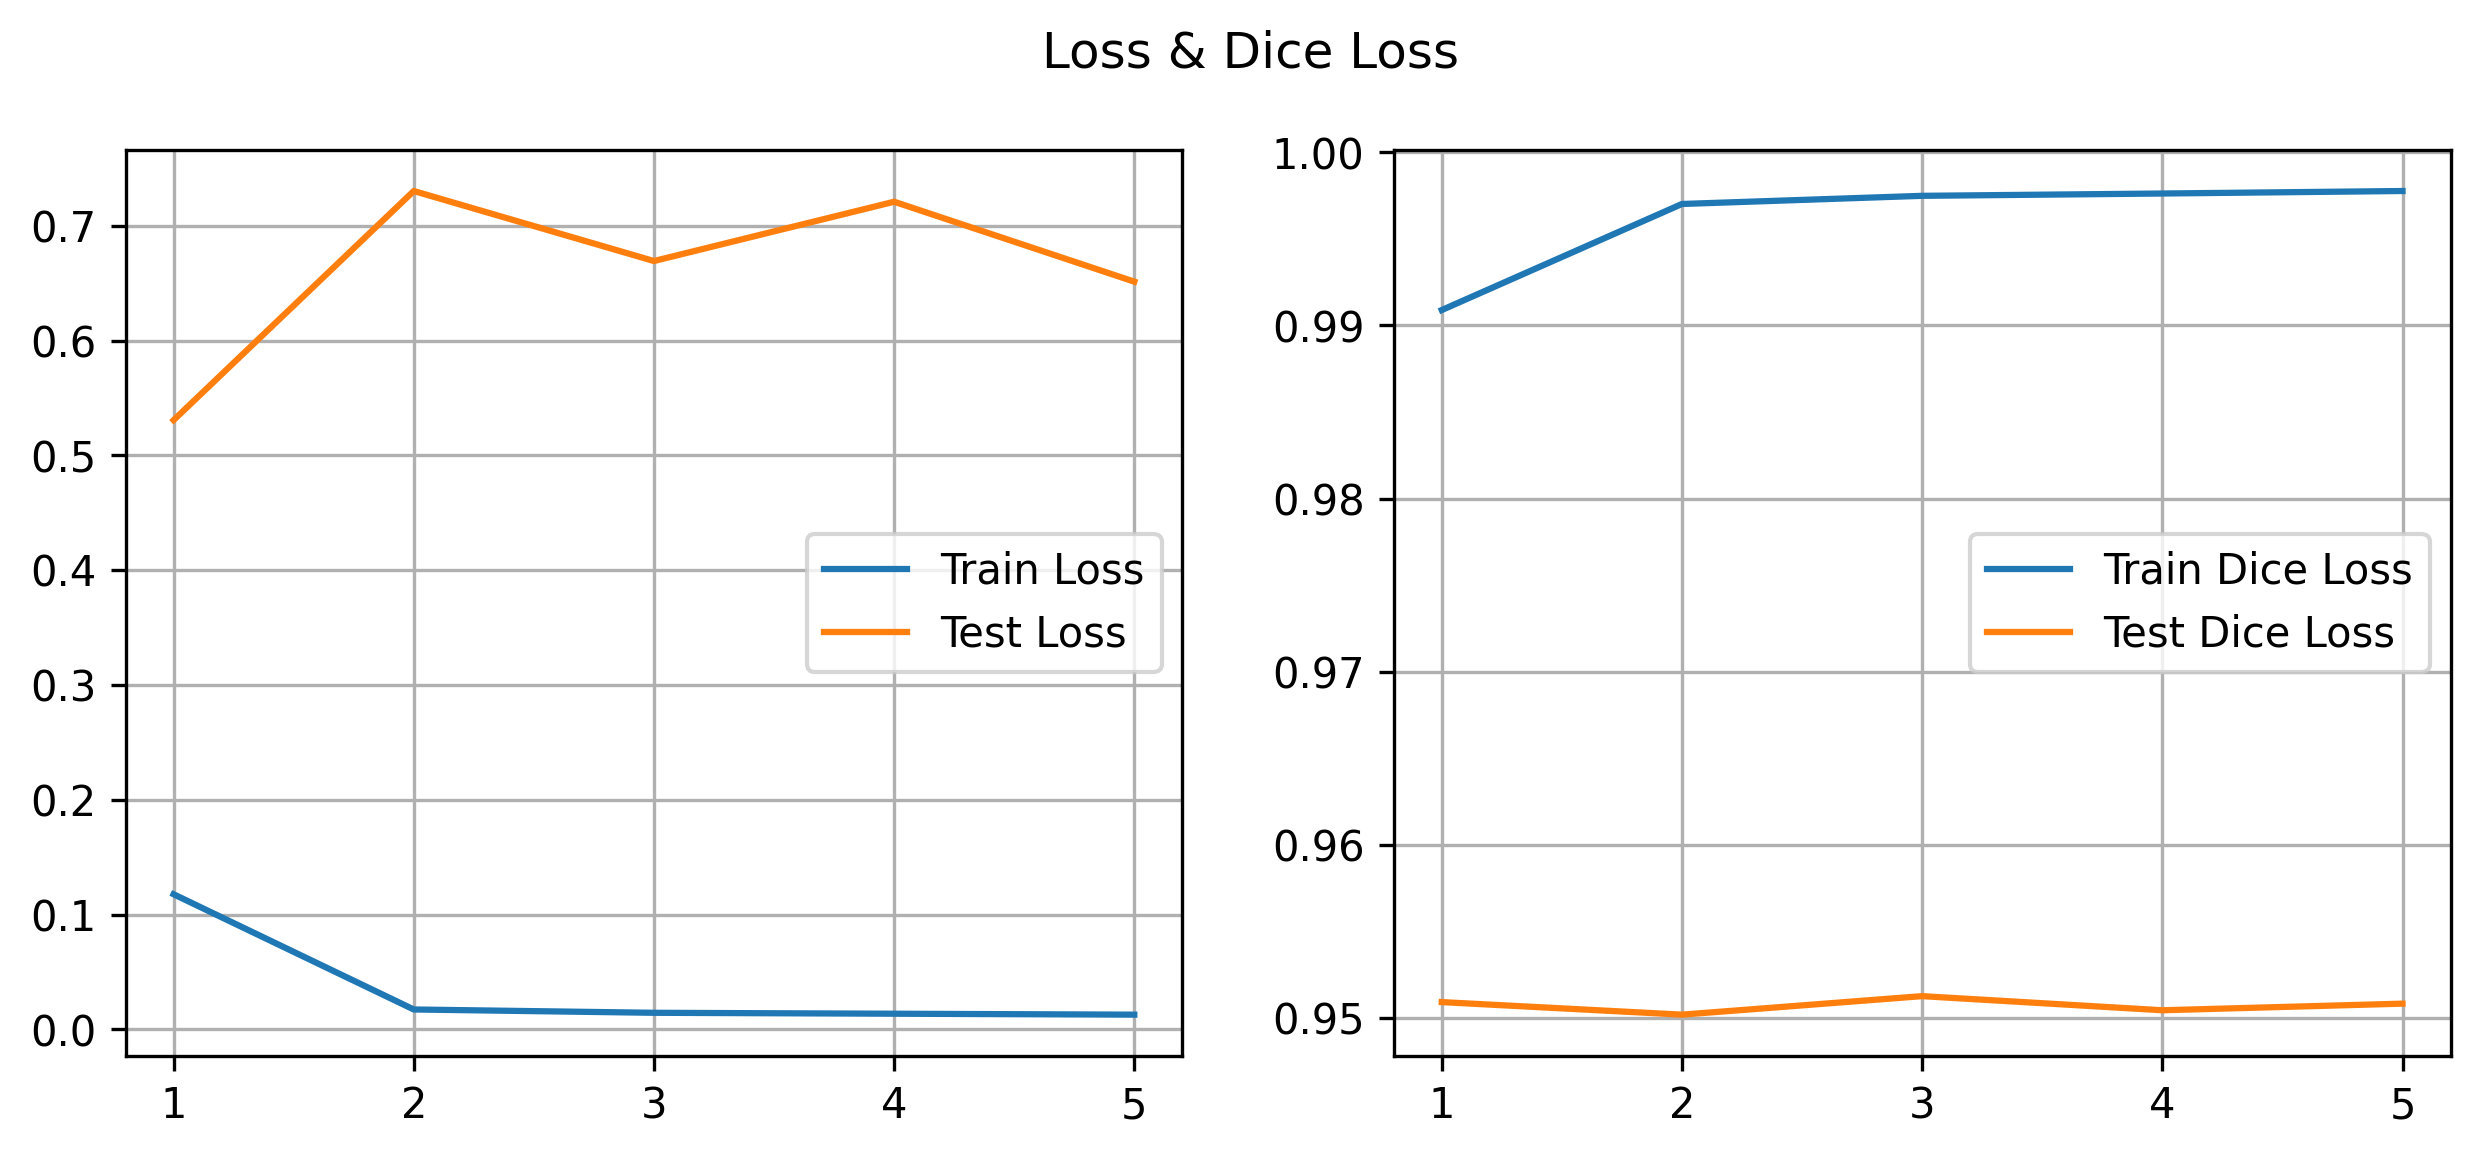

In [ ]:
plt.figure(figsize=(10, 4), dpi=300)
plt.suptitle('Loss & Dice Loss')
plt.subplot(121)
plt.plot(range(1, 5+1), history.history['loss'], label='Train Loss')
plt.plot(range(1, 5+1), history.history['val_loss'], label='Test Loss')
plt.grid()
plt.legend()
plt.subplot(122)
plt.plot(range(1, 5+1), history.history['dice_loss'], label='Train Dice Loss')
plt.plot(range(1, 5+1), history.history['val_dice_loss'], label='Test Dice Loss')
plt.grid()
plt.legend()

(5, 256, 256, 3) (5, 256, 256, 1)


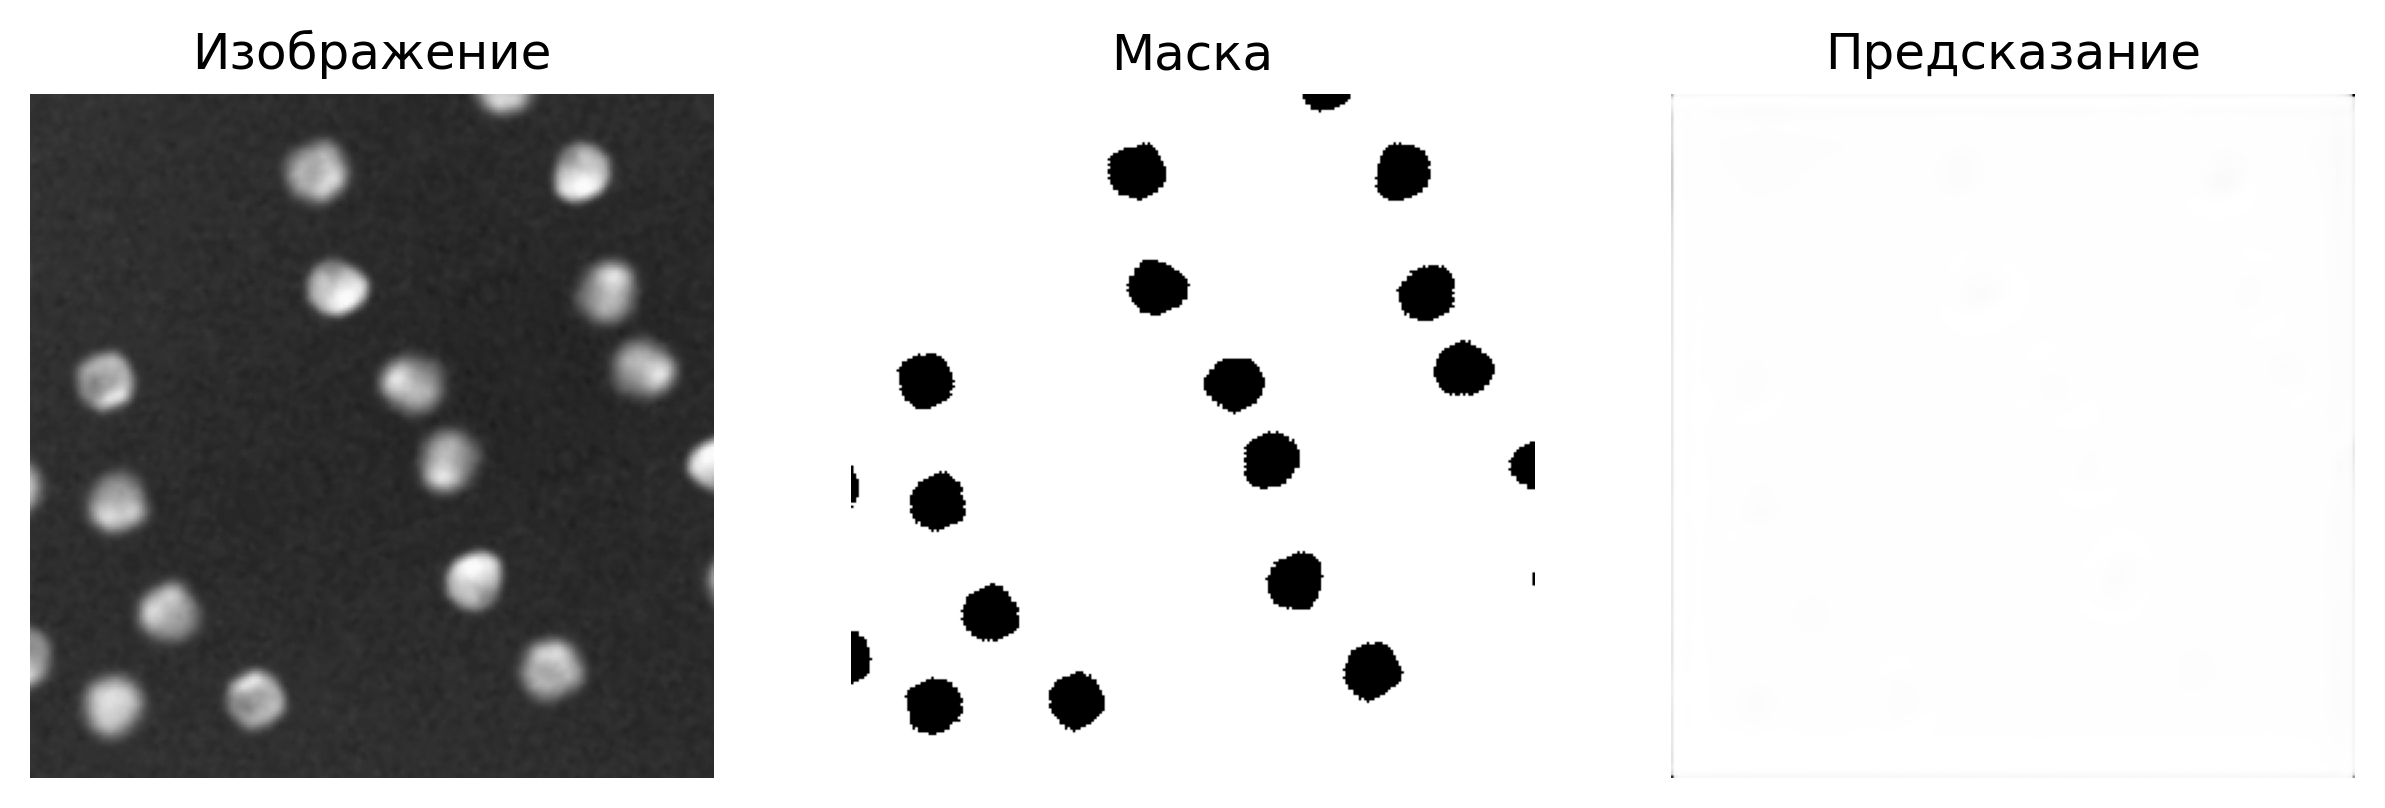

In [ ]:
rand_num = np.random.randint(X_test.size)
img, mask = next(batch_generator(X_test, Y_test, 5))
print(img.shape, mask.shape)

plt.figure(dpi=300, figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title('Изображение')
plt.axis('off')
plt.imshow(img[0], cmap='Greys')
plt.subplot(1, 3, 2)
plt.title('Маска')
plt.axis('off')
plt.imshow(mask[0][..., 0], cmap='Greys')
plt.subplot(1, 3, 3)
plt.title('Предсказание')
plt.axis('off')
plt.imshow(
    # np.around(
        model.predict(img)[0][..., 0]
        # )
    , 
        cmap='Greys')

# Testing on initial images

In [4]:
init_img = cv.imread('/content/drive/MyDrive/ООП проект/Эмбриологические_снимки/image0013.tif')
init_img = cv.cvtColor(init_img, cv.COLOR_BGR2RGB)

In [5]:
init_img.shape

(1440, 1920, 3)

In [6]:
def cropped_img(img, threshold=0):
    threshold = np.argwhere(img[..., 0] > threshold)
    (ystart, xstart), (ystop, xstop) = threshold.min(0), threshold.max(0) + 1 
    return img[ystart:ystop, xstart:xstop, ...]

In [7]:
crp_img = cropped_img(init_img, threshold=130)

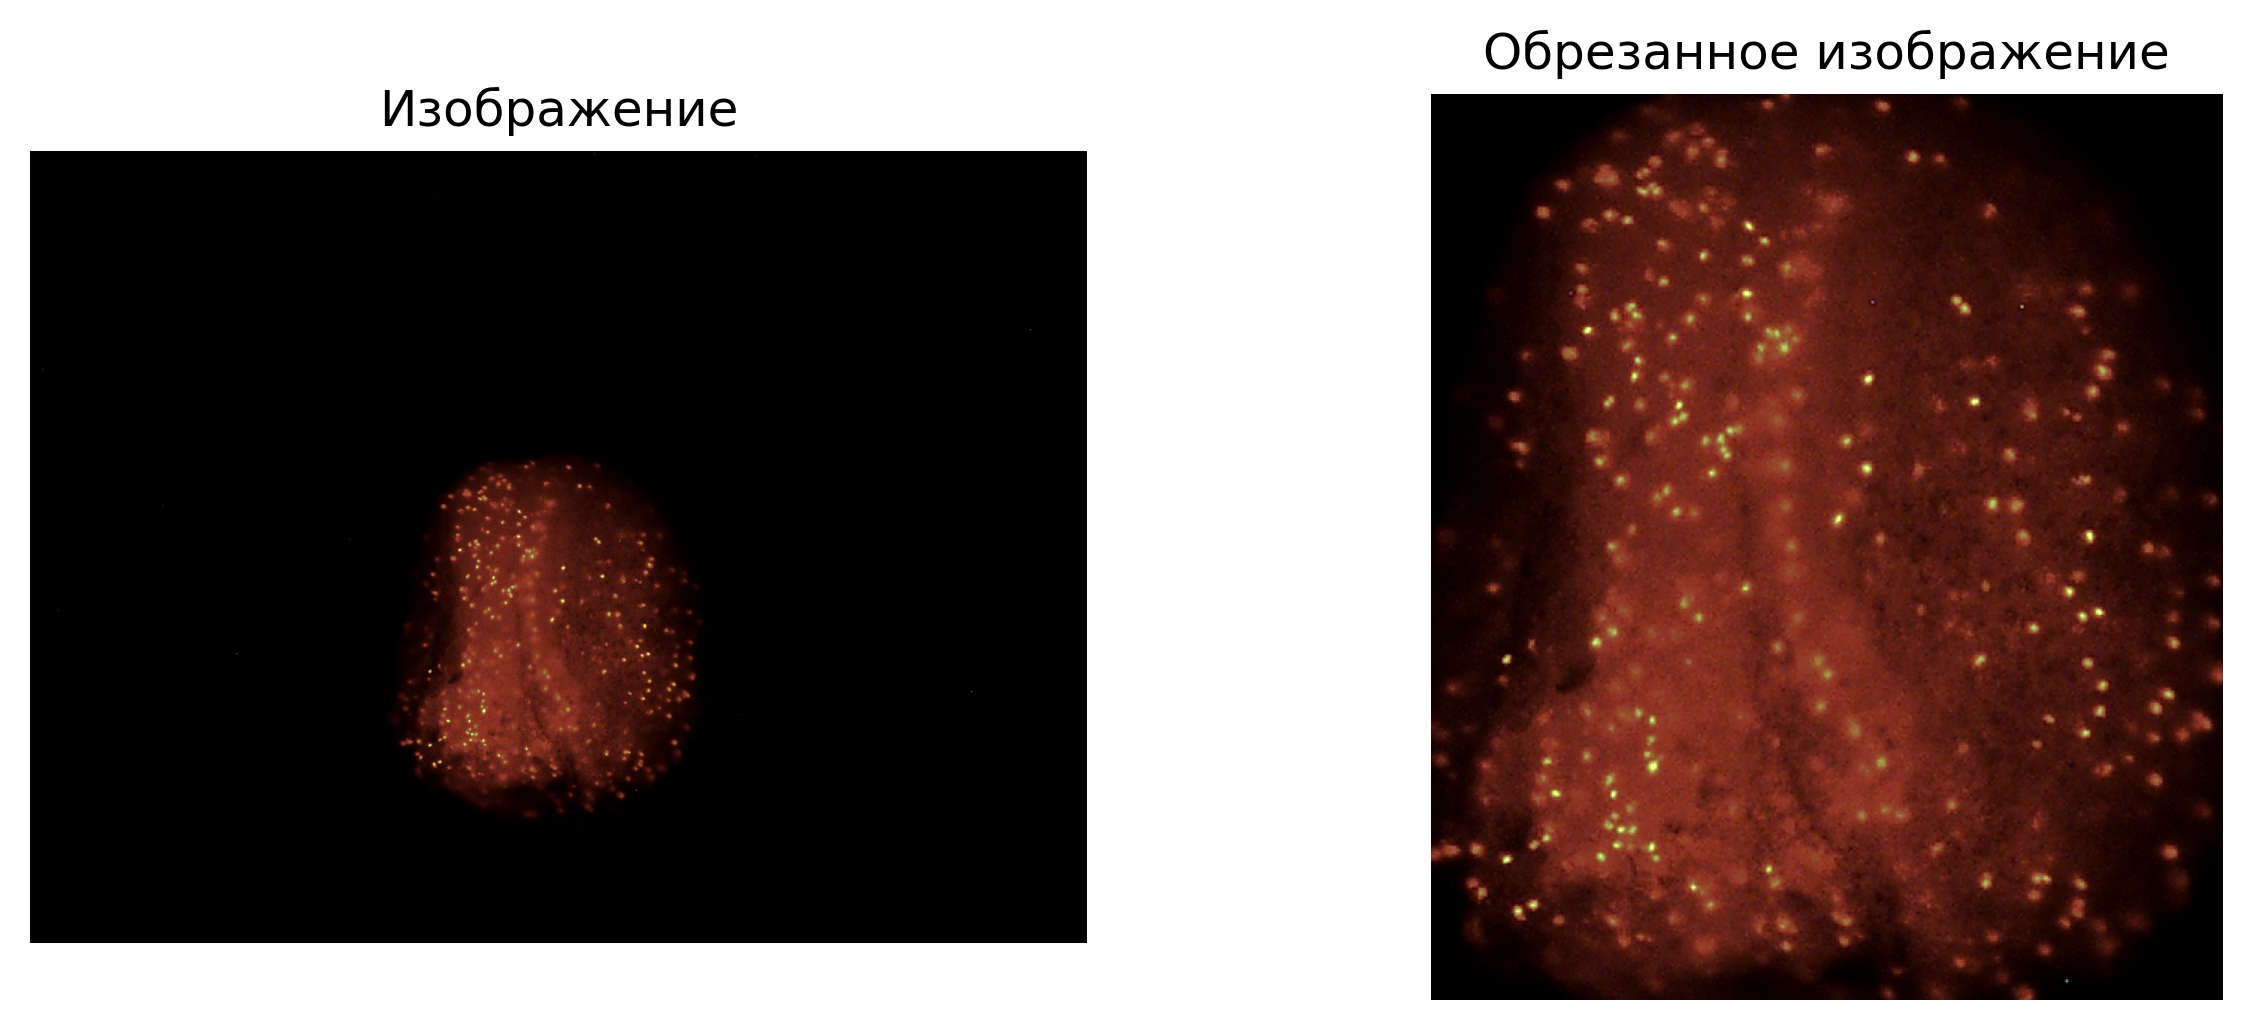

In [ ]:
plt.figure(dpi=300, figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Изображение')
plt.axis('off')
plt.imshow(init_img, cmap='Greys')
plt.subplot(1, 2, 2)
plt.title('Обрезанное изображение')
plt.axis('off')
plt.imshow(crp_img, cmap='Greys')

In [8]:
crp_img = cv.resize(crp_img, (256, 256)) / 255

In [9]:
crp_img.shape

(256, 256, 3)

In [ ]:
plt.figure(dpi=300, figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Изображение')
plt.axis('off')
plt.imshow(crp_img, cmap='Greys')
plt.subplot(1, 2, 2)
plt.title('Маска (нейросеть)')
plt.axis('off')
plt.imshow(model.predict(np.expand_dims(crp_img, 0))[0][..., 0]>0.1, cmap='Greys')

# Saving model structure & weights

In [ ]:
model.save('/content/drive/MyDrive/Физтех/ООП проект/NeuralNetwork')

In [12]:
def dice_loss(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (
        (2. * intersection + smooth) / 
        (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)
    )

# Loading model

In [13]:
model = keras.models.load_model('/content/drive/MyDrive/ООП проект/NeuralNetwork', custom_objects={'dice_loss':dice_loss})

In [11]:
import keras

In [14]:
init_img = cv.imread('/content/drive/MyDrive/ООП проект/Эмбриологические_снимки/image0013.tif')
init_img = cv.cvtColor(init_img, cv.COLOR_BGR2RGB)
crp_img = cv.resize(cropped_img(init_img, threshold=130), (256, 256)) / 255

AttributeError: ignored

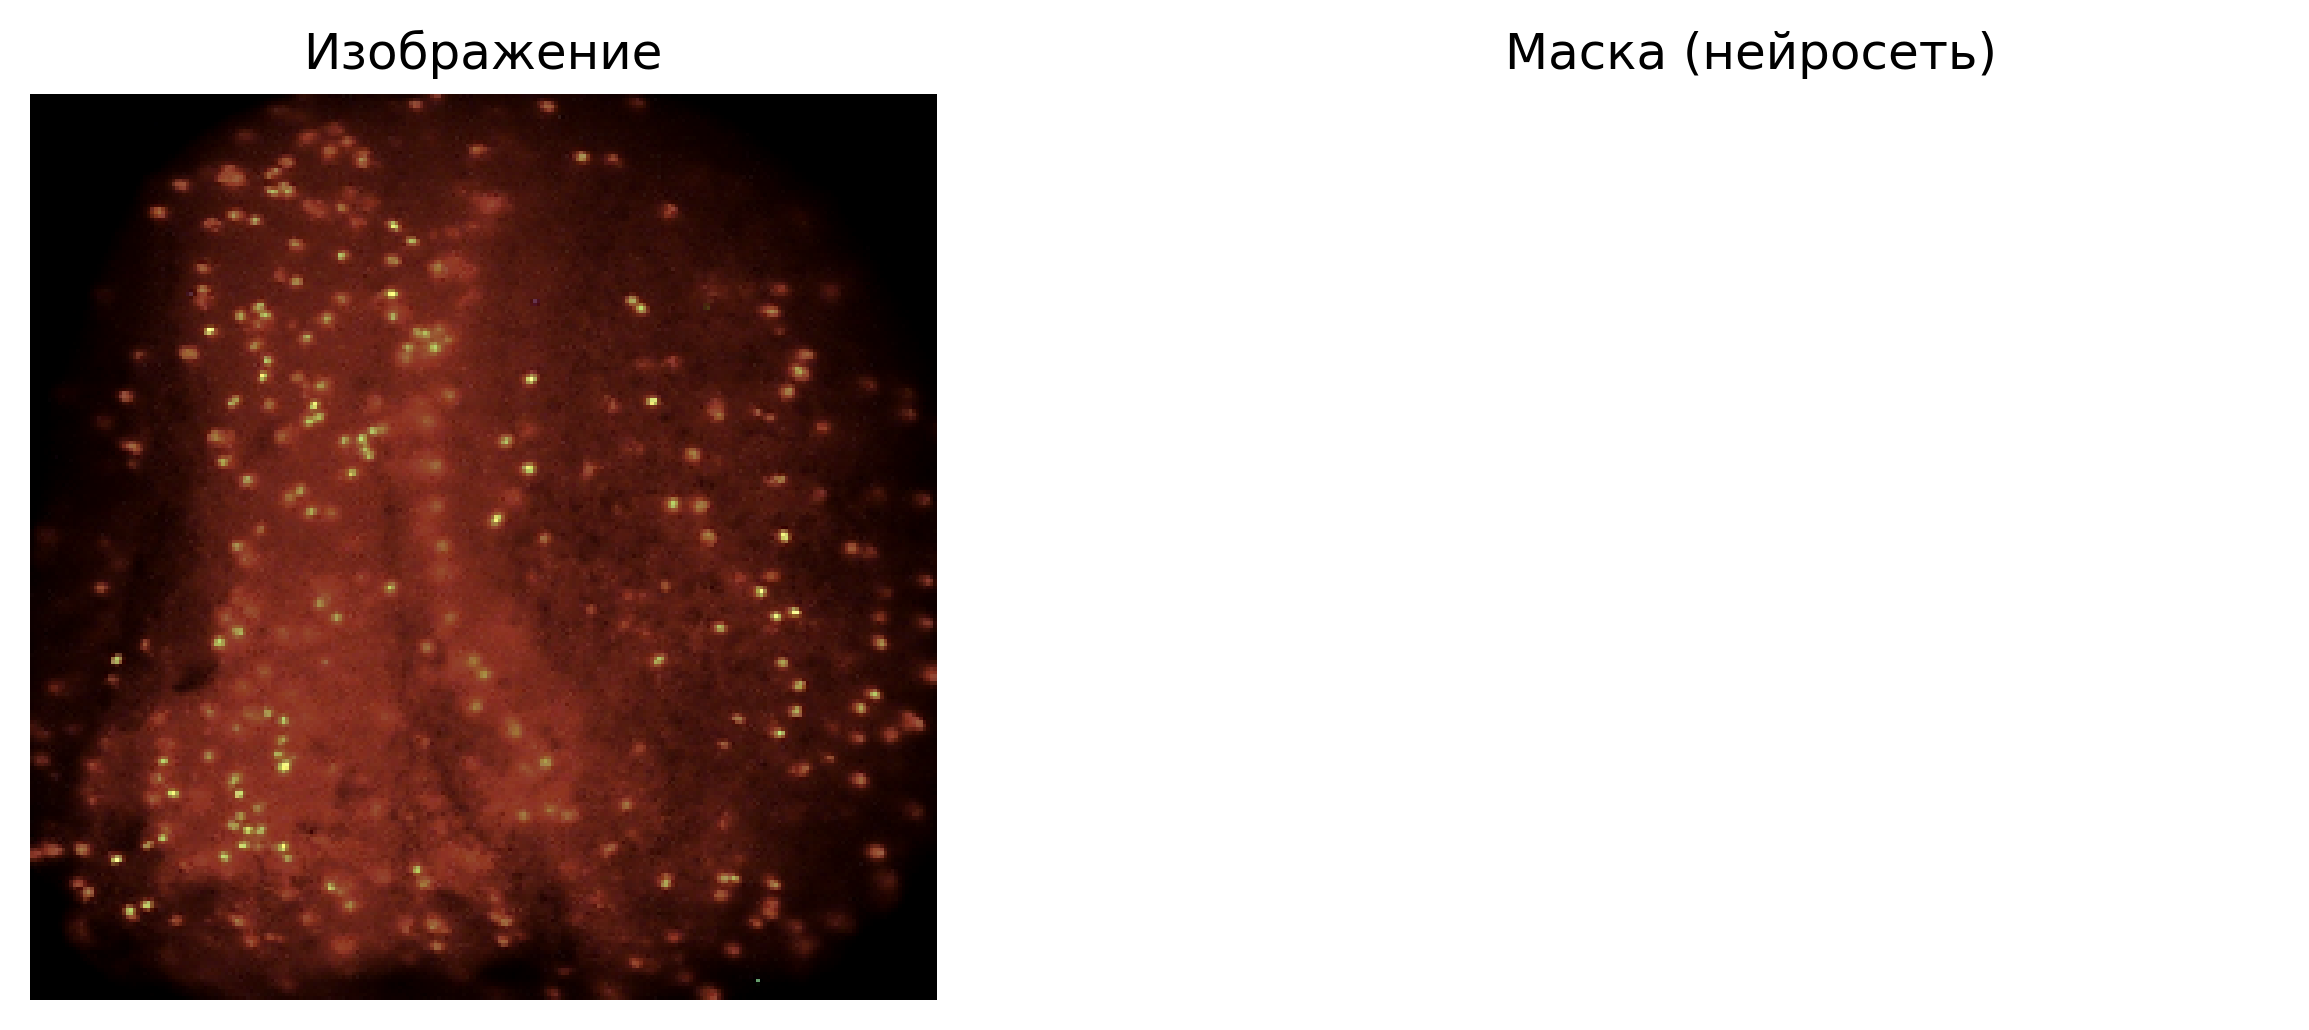

In [ ]:
plt.figure(dpi=300, figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Изображение')
plt.axis('off')
plt.imshow(crp_img, cmap='Greys')
plt.subplot(1, 2, 2)
plt.title('Маска (нейросеть)')
plt.axis('off')
plt.imshow(model.predict(np.expandmask[0][..., 0], cmap='Greys'))

# Clustering algorithm to count cells

In [ ]:
DBSCAN
1. отделить по яркости фон
2. алгоритм кластеризации
3. проверка кластеров на невыпклость
4. невыпуклые кластеры передаем нейронке


SyntaxError: ignored

In [24]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


In [16]:
mask = model.predict(np.expand_dims(crp_img, 0))[0][..., 0]>0.1 #маска предикшна далее в tsne

In [17]:
mask_1 = mask.astype(int)
print(mask_1)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [18]:
ind_i = []
ind_j = []
for i in range(len(mask_1)):
  for j in range(len(mask_1[i])):
      if mask_1[i][j] == 1:
        ind_i.append(i)
        ind_j.append(j)
print(ind_i)
print(ind_j)

[3, 3, 10, 10, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28, 28, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 38, 38, 38, 41, 41, 41, 42, 42, 42, 42, 42, 43, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 4

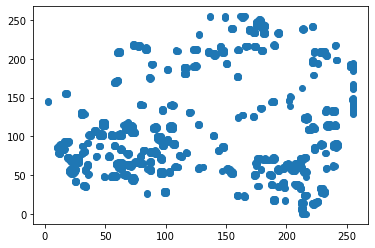

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(ind_i,ind_j)
plt.show()

In [20]:
A = list(zip(ind_i,ind_j))
coord = list(map(list,A))

DBSCAN

In [2]:
from sklearn.cluster import DBSCAN
dbscan_repr = DBSCAN(min_samples = 3, eps = 1).fit_predict(df)
print(dbscan_repr)

NameError: ignored

In [27]:
np.vstack(np.unique(dbscan_repr, return_counts = True))

array([[ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168],
       [  7,   2,   2,   9,  22,  13,

In [28]:
#df из двумерного массива
df = pd.DataFrame(coord)
df.columns = ['ind_i', 'ind_j']

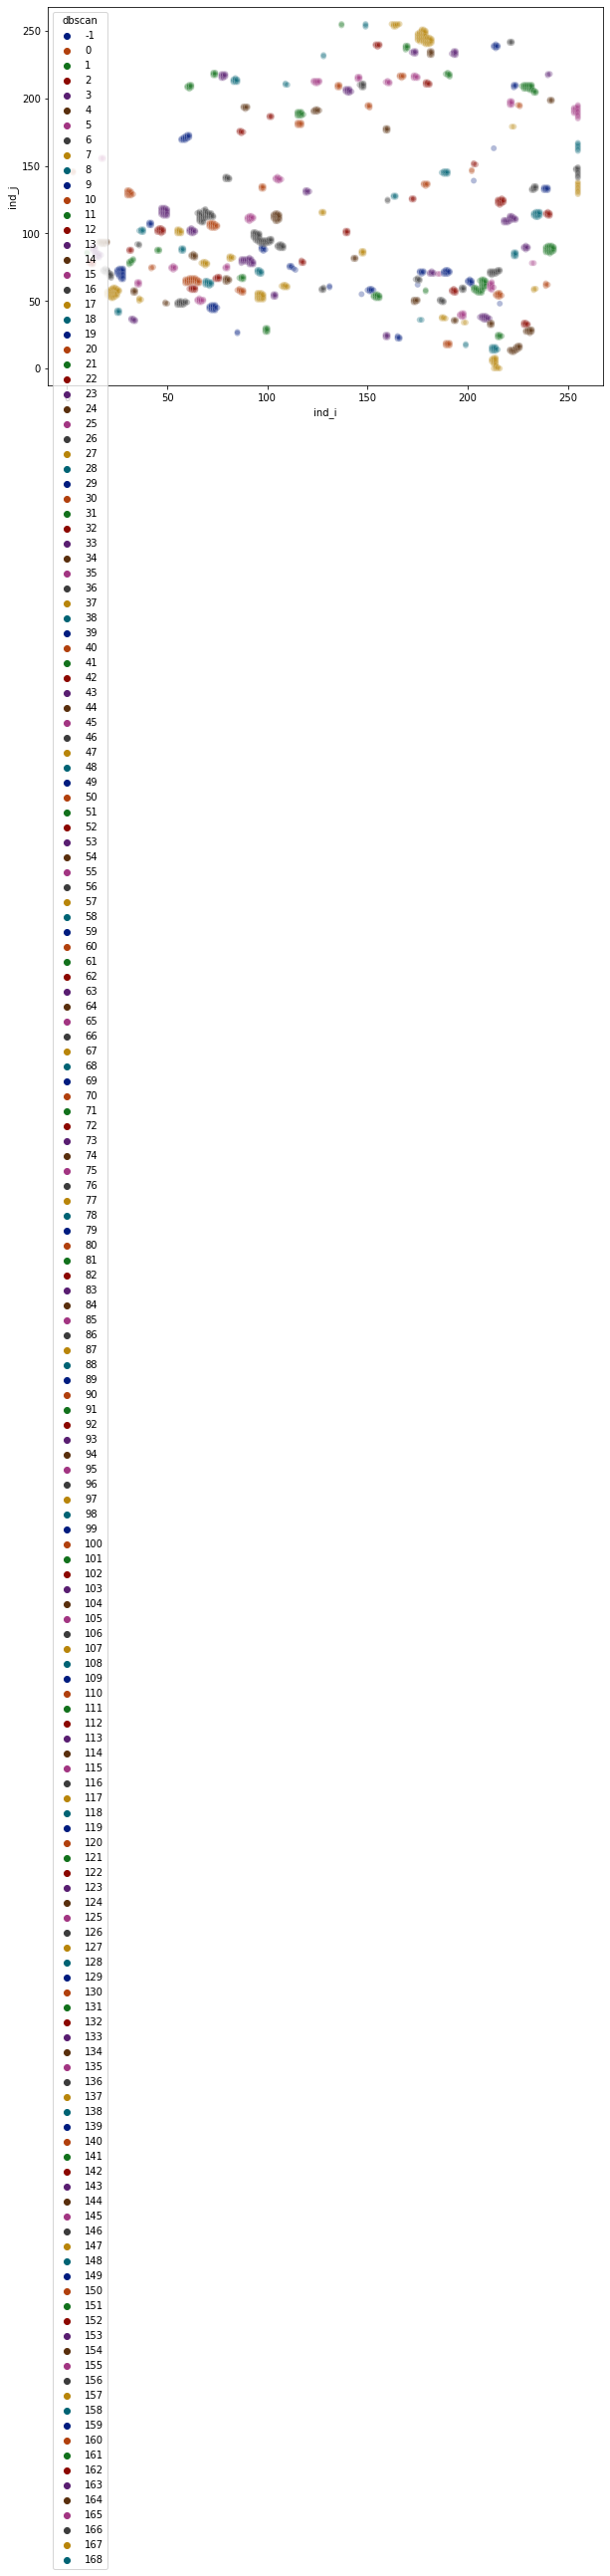

In [31]:
df["dbscan"] = dbscan_repr
plt.figure(figsize = (10,7))
sns.scatterplot(
    x = "ind_i", y = "ind_j",
    hue = "dbscan",
    palette = sns.color_palette("dark",170),
    data = df,
    legend ="full",
    alpha = 0.3
)

In [32]:
# метрика качества кластеризации
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps = 3, min_samples =4)

model=dbscan.fit(coord)
labels = dbscan_repr

from sklearn import metrics

sample_cores = np.zeros_like(labels,dtype = bool)

sample_cores[dbscan.core_sample_indices_] = True

n_clusters = len(set(labels))-(1 if -1 in labels else 0)
print(metrics.silhouette_score(coord,labels))

0.687450994381554
